<a href="https://colab.research.google.com/github/chelynl/darts_python/blob/main/Time_Series_Using_Darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will explore various time series model using the Darts library including:
- Exponential Smoothing Models
- ARIMA models
- ARIMAX models

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# !pip install u8darts[all]
from darts import TimeSeries, ModelMode
from darts.models import ExponentialSmoothing, AutoARIMA
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper
from darts.dataprocessing import Pipeline
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, extract_trend_and_seasonality
from darts.utils.timeseries_generation import linear_timeseries

Import Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
oz_df = pd.read_csv('/content/drive/MyDrive/NCSU MSA/Fall Term II/Time Series/Data/Ozone_Raleigh2.csv')
co_df = pd.read_csv('/content/drive/MyDrive/NCSU MSA/Fall Term II/Time Series/Data/CO_Raleigh.csv')
no_df = pd.read_csv('/content/drive/MyDrive/NCSU MSA/Fall Term II/Time Series/Data/NO_Raleigh.csv')
weather_df = pd.read_csv('/content/drive/MyDrive/NCSU MSA/Fall Term II/Time Series/Data/Raleigh_weather.csv')
so2_df = pd.read_csv('/content/drive/MyDrive/NCSU MSA/Fall Term II/Time Series/Data/SO2_Raleigh.csv')

Start exploring data

In [ ]:
# # See preview of each df
# oz_df.head()
# co_df.head()
# no_df.head()
# so2_df.head()

# See datacol types
oz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2283 entries, 0 to 2282
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  2283 non-null   object 
 1   Source                                2283 non-null   object 
 2   Site ID                               2283 non-null   int64  
 3   POC                                   2283 non-null   int64  
 4   Daily Max 8-hour Ozone Concentration  2283 non-null   float64
 5   UNITS                                 2283 non-null   object 
 6   DAILY_AQI_VALUE                       2283 non-null   int64  
 7   Site Name                             2283 non-null   object 
 8   DAILY_OBS_COUNT                       2283 non-null   int64  
 9   PERCENT_COMPLETE                      2283 non-null   int64  
 10  AQS_PARAMETER_CODE                    2283 non-null   int64  
 11  AQS_PARAMETER_DES

In [13]:
# Rename col names to make them easier to handle
oz_df.rename(columns={'Daily Max 8-hour Ozone Concentration':'daily_max_oz'}, inplace=True)
co_df.rename(columns={'Daily Max 8-hour CO Concentration':'daily_max_co'}, inplace=True)
no_df.rename(columns={'Daily Max 1-hour NO2 Concentration':'daily_max_no'}, inplace=True)
so2_df.rename(columns={'Daily Max 1-hour SO2 Concentration':'daily_max_so'}, inplace=True)

# Convert Date cols to datetime 
oz_df['Date'] = pd.to_datetime(oz_df['Date'])
co_df['Date'] = pd.to_datetime(co_df['Date'])
no_df['Date'] = pd.to_datetime(no_df['Date'])
so2_df['Date'] = pd.to_datetime(so2_df['Date'])

In [14]:
print('Start Date: ', oz_df['Date'].iloc[0])
print('End Date: ', oz_df['Date'].iloc[-1])

# Preview ozone df
oz_df.head()

Start Date:  2014-01-01 00:00:00
End Date:  2020-05-31 00:00:00


,Date,Source,Site ID,POC,daily_max_oz,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,2014-01-01,AQS,371830014,1,0.026,ppm,24,Millbrook School,17,100,44201,Ozone,39580,"Raleigh, NC",37,North Carolina,183,Wake,35.856111,-78.574167
1,2014-01-02,AQS,371830014,1,0.017,ppm,16,Millbrook School,17,100,44201,Ozone,39580,"Raleigh, NC",37,North Carolina,183,Wake,35.856111,-78.574167
2,2014-01-03,AQS,371830014,1,0.035,ppm,32,Millbrook School,17,100,44201,Ozone,39580,"Raleigh, NC",37,North Carolina,183,Wake,35.856111,-78.574167
3,2014-01-04,AQS,371830014,1,0.030,ppm,28,Millbrook School,17,100,44201,Ozone,39580,"Raleigh, NC",37,North Carolina,183,Wake,35.856111,-78.574167
4,2014-01-05,AQS,371830014,1,0.023,ppm,21,Millbrook School,17,100,44201,Ozone,39580,"Raleigh, NC",37,North Carolina,183,Wake,35.856111,-78.574167


In [15]:
# Identify missing values with NaN and make ts objects for each df
oz_nulls_ts = TimeSeries.from_dataframe(oz_df, time_col='Date', value_cols='daily_max_oz', freq='D', fill_missing_dates=True)
co_nulls_ts = TimeSeries.from_dataframe(co_df, 'Date', 'daily_max_co', freq='D', fill_missing_dates=True)
no_nulls_ts = TimeSeries.from_dataframe(no_df, 'Date', 'daily_max_no', freq='D', fill_missing_dates=True)
so2_nulls_ts = TimeSeries.from_dataframe(so2_df, 'Date', 'daily_max_so', freq='D', fill_missing_dates=True)

# Impute missing values and re-assign ts objects
filler = MissingValuesFiller()
oz_imputed_ts = filler.transform(oz_nulls_ts, method='quadratic') # use pd.interpolate() args when calling transform(), method='linear' is default
co_imputed_ts = filler.transform(co_nulls_ts, method='quadratic')
no_imputed_ts = filler.transform(no_nulls_ts, method='quadratic')
so2_imputed_ts = filler.transform(so2_nulls_ts, method='quadratic')

We will first roll up the data to the monthly level and try fitting an exponentia smoothing model.

In [91]:
# Monthly ozone
monthly_oz = oz_df.resample(rule='M').mean()

# Change col name from daily to monthly oz conc
monthly_oz.rename(columns={'daily_max_oz': 'monthly_max_oz'}, inplace=True)

# Reset index to use Date col for creating ts object
monthly_oz.reset_index(inplace=True)

monthly_oz.head()

,Date,Site ID,POC,monthly_max_oz,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,CBSA_CODE,STATE_CODE,COUNTY_CODE,SITE_LATITUDE,SITE_LONGITUDE
0,2014-01-31,371830014.0,1.0,0.028552,26.448276,17.0,100.0,44201.0,39580.0,37.0,183.0,35.856111,-78.574167
1,2014-02-28,371830014.0,1.0,0.034607,32.107143,17.0,100.0,44201.0,39580.0,37.0,183.0,35.856111,-78.574167
2,2014-03-31,371830014.0,1.0,0.042355,39.741935,17.0,100.0,44201.0,39580.0,37.0,183.0,35.856111,-78.574167
3,2014-04-30,371830014.0,1.0,0.048233,47.500000,17.0,100.0,44201.0,39580.0,37.0,183.0,35.856111,-78.574167
4,2014-05-31,371830014.0,1.0,0.049419,47.870968,17.0,100.0,44201.0,39580.0,37.0,183.0,35.856111,-78.574167


In [102]:
# Create monthly ts object
monthly_ts = TimeSeries.from_dataframe(monthly_oz, time_col='Date', value_cols='monthly_max_oz', freq='M')

# Get training+validation and test sets
train_valid, test = monthly_ts.split_before(pd.Timestamp('2020-01-31'))
# Split training+validation into respective parts
train, valid = train_valid.split_before(pd.Timestamp('2019-01-31'))

Text(0.5, 1.0, 'Time Plot of Raw Training')

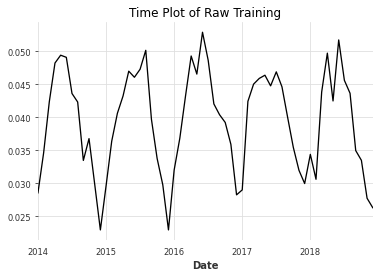

In [103]:
# Visualize the plot --> additive seasonality since variance is fairly constant
train.plot()
plt.title('Time Plot of Raw Training')

In [16]:
# Get training+validation and test sets
train_valid, test = oz_imputed_ts.split_after(pd.Timestamp('2020-05-17')) # test set is the last 14 days

# Split Training+Validation into respective parts
train, valid = train_valid.split_before(pd.Timestamp('2020-04-20')) # validation set is last 28 days from combined data

Text(0.5, 1.0, 'Time Plot of Raw Training')

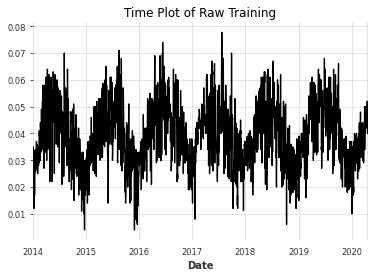

In [17]:
# Visualize the plot --> additive seasonality since variance is fairly constant
train.plot()
plt.title('Time Plot of Raw Training')

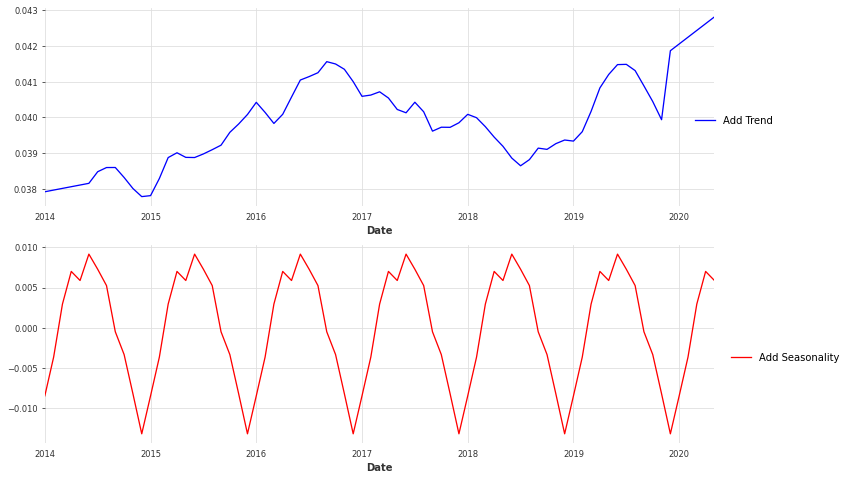

In [116]:
# Create enums for additive models since
add = ModelMode('additive')

# Extract and assign vars to trend and seasonality
add_trend = extract_trend_and_seasonality(monthly_ts, freq=12, model=add)[0]
add_seasonal = extract_trend_and_seasonality(monthly_ts, freq=12, model=add)[1]

# Plot trends and seasonality
plt.figure(figsize=(12,8))
plt.subplot(211)
add_trend.plot(label='Add Trend', color="blue")
plt.legend(loc='best', bbox_to_anchor=(0.6, 0., 0.5, 0.5))
plt.subplot(212)
add_seasonal.plot(label='Add Seasonality', color='red')
plt.legend(loc='best', bbox_to_anchor=(0.7, 0., 0.5, 0.5))

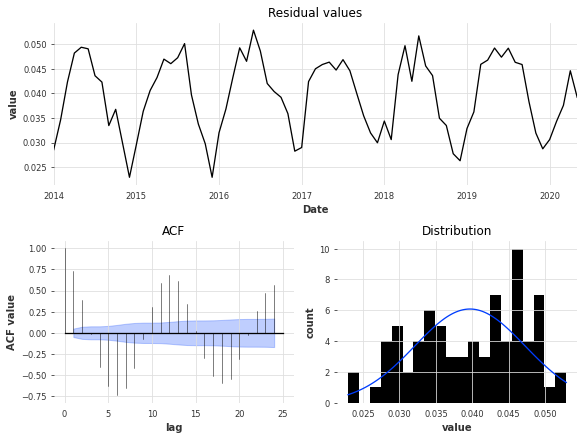

In [117]:
# See residuals
plot_residuals_analysis(monthly_ts)

Text(0.5, 1.0, 'ESM: Predicted vs. Actual')

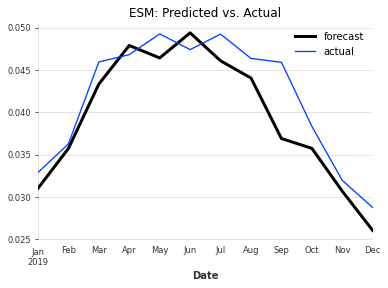

In [118]:
# Initalize Exponential Smoothing model; additive by default
esm = ExponentialSmoothing()

# Fit model to training data
esm.fit(train)

# Get validation predictions
valid_pred = esm.predict(len(valid))

valid_pred.plot(label='forecast', lw=3)
valid.plot(label='actual')
plt.legend()
plt.title('ESM: Predicted vs. Actual')

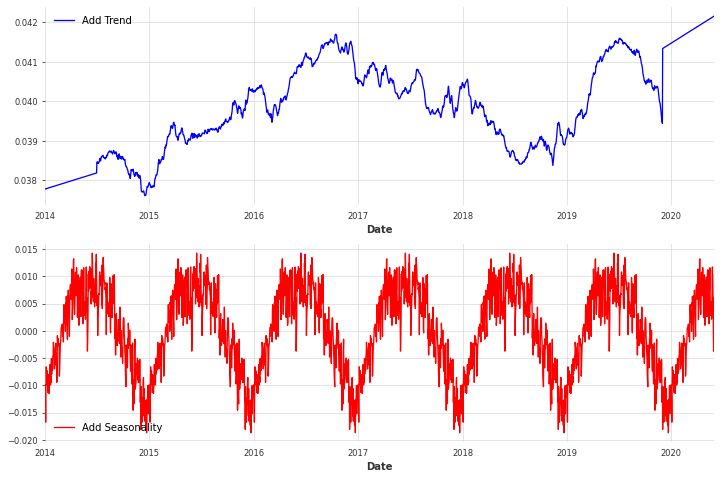

In [69]:
# Create enums for additive models since
add = ModelMode('additive')

# Extract and assign vars to trend and seasonality
add_trend = extract_trend_and_seasonality(oz_imputed_ts, freq=365, model=add)[0]
add_seasonal = extract_trend_and_seasonality(oz_imputed_ts, freq=365, model=add)[1]

# Plot trends and seasonality
plt.figure(figsize=(12,8))
plt.subplot(211)
add_trend.plot(label='Add Trend', color="blue")
plt.legend(loc='best')
plt.subplot(212)
add_seasonal.plot(label='Add Seasonality', color='red')
plt.legend(loc='best')

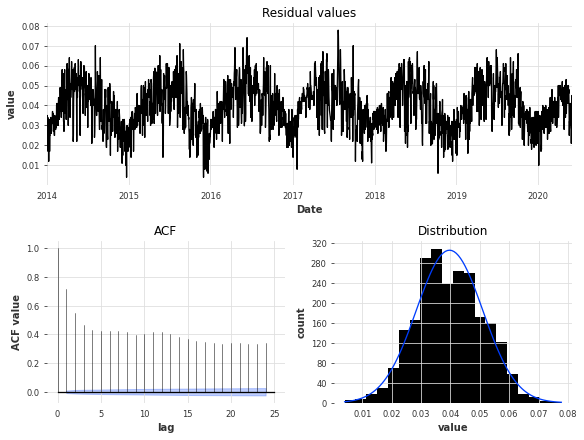

In [70]:
# See residuals
plot_residuals_analysis(oz_imputed_ts)